<a href="https://colab.research.google.com/github/Sharon-Liu97/Luxury-Car-Analysis/blob/main/unstructured_data_A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis for Luxury Car Market

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from math import log

import requests
from bs4 import BeautifulSoup
from time import sleep
from random import randint

import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams

from sklearn import manifold
from sklearn.manifold import MDS
from sklearn.linear_model import LinearRegression


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# TASK 0: Scraping Data

1. Forum link: https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans

We used early 5000 posts which are in the first ~100 pages

In [ ]:
!pip install selenium
!apt-get -q update   #Used to handle installation and removal of softwares and libraries
!apt install -yq chromium-chromedriver #ChromeDriver is a separate executable that Selenium WebDriver uses to control Chrome.
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
from selenium.webdriver.common.by import By

#WebDriver is a browser automation framework that works with open source APIs. 
#The framework operates by accepting commands, sending those commands to a browser, and interacting with applications.
chrome_options = webdriver.ChromeOptions()
#headless means running chrome with chrome.exe
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 985 kB 4.5 MB/s 
     |████████████████████████████████| 140 kB 39.1 MB/s 
     |████████████████████████████████| 358 kB 36.2 MB/s 
     |████████████████████████████████| 58 kB 2.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.12 which is incompatible.


Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:14 http://ppa.launchpad.net

In [ ]:
wd = webdriver.Chrome('chromedriver',options=chrome_options)

In [ ]:
#Scraper
df=pd.DataFrame(columns=['userid','time','comment'])
time = []
user = []
comment = []
for page in range(103):
  page = requests.get('https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p'+str(page))
  soup = BeautifulSoup(page.text, 'html.parser')
  comment_data = soup.findAll('li', attrs = {'class': ['Item ItemComment noPhotoWrap Role_Member pageBox','Item Alt ItemComment noPhotoWrap Role_Member pageBox']})
  sleep(randint(2,5))
  for cmnt in comment_data:
    time_review = cmnt.find('span', class_ = "MItem DateCreated").text.replace('\n', '')
    time.append(time_review)

    user_id = cmnt.find('span', class_ = "Author").text.replace('\n', '')
    user.append(user_id)

    user_comment = cmnt.find('div', class_ = "Message userContent").text.replace('\n', '')
    comment.append(user_comment)

comment_df = pd.DataFrame({ "Userid": user, "Time" : time, "Comment": comment})
comment_df.to_csv('comments.csv')

In [ ]:
comments = pd.read_csv('comments.csv')
comments.drop('Unnamed: 0',axis=1, inplace=True)
comments.dropna(inplace=True)
comments.columns= ['reviewer','date','comment']
comments.head(5)

,reviewer,date,comment
0,merc1,March 2002,I personally think that with a few tweaks the ...
1,fredvh,March 2002,I am debating a new purchase and these two are...
2,blueguydotcom,March 2002,"Great handling, RWD, excellent engine and the ..."
3,hungrywhale,March 2002,And no manual tranny. That may not matter to y...
4,riez,March 2002,One beauty of BMW 3 Series is that there are s...


# TASK A: Test Zipf's Law

To test Zipf's Law, we need to test:

$ ln\,f(r) = -ln\,r + ln\,c$<br><br>

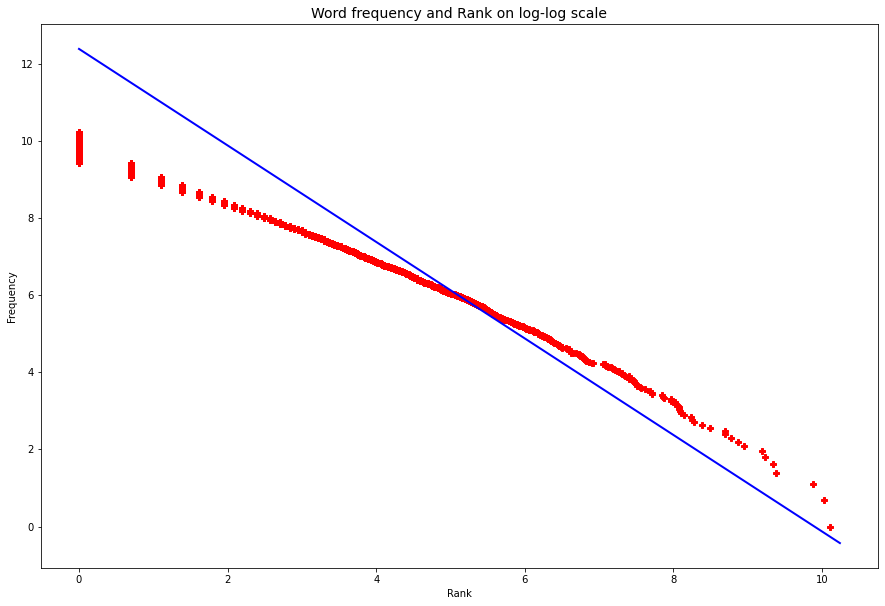

In [ ]:
# Plotting log(Frequency) Vs log(Rank)
comments['tokenization'] = comments['comment'].apply(word_tokenize)
ini_word_freq_dict = dict()

def freqCount(cmnt):
  for word in cmnt:
    if word in ini_word_freq_dict:
      ini_word_freq_dict[word] +=1
    else:
      ini_word_freq_dict[word] = 1
  return ini_word_freq_dict

full_ini_cmnt = [word for l in comments['tokenization'].values for word in l]
ini_word_freq_dict = freqCount(full_ini_cmnt)

from math import log
freq = sorted(ini_word_freq_dict.values(),reverse=True)
rank = [i+1 for i in range(len(freq))]

log_freq = np.reshape([log(x) for x in freq],(-1,1))
log_rank = np.reshape([log(x) for x in rank],(-1,1))

from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(log_rank, log_freq)
freq_pred = reg.predict(log_rank)


plt.figure(figsize=(15,10))
plt.plot(log_freq,log_rank,color='r',marker='P', linewidth=0)
plt.title('Word frequency and Rank on log-log scale', fontsize=14)
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.plot(log_rank, freq_pred, color='blue', linewidth=2)

# TASK B

## Tokenization + Stop Words Removal + Replace Model with Brand

In [ ]:
#comments['tokenization'] = comments['comment'].apply(word_tokenize)
stop_words = stopwords.words('english') + list(string.punctuation)

model = pd.read_csv('model.csv')
model_dict = pd.Series(model['Brand'].values, index=model['Model']).to_dict()

def filtered(tokens):
  no_stopwords = [word.lower() for word in tokens if word.lower() not in stop_words]
  replace_model = [model_dict[word] if word in model_dict else word for word in no_stopwords]
  return list(set(replace_model))

comments['filtered_cmnt'] = comments['tokenization'].apply(filtered)
comments_df = comments.copy()

In [ ]:
comments_df

,reviewer,date,comment,tokenization,filtered_cmnt
0,merc1,March 2002,I personally think that with a few tweaks the ...,"[I, personally, think, that, with, a, few, twe...","[sub-40k, price, ago, also, excellent, 3.0, x-..."
1,fredvh,March 2002,I am debating a new purchase and these two are...,"[I, am, debating, a, new, purchase, and, these...","[price, co., compare, generation, importance, ..."
2,blueguydotcom,March 2002,"Great handling, RWD, excellent engine and the ...","[Great, handling, ,, RWD, ,, excellent, engine...","[winner, best, around, handling, easy, excelle..."
3,hungrywhale,March 2002,And no manual tranny. That may not matter to y...,"[And, no, manual, tranny, ., That, may, not, m...","[may, let, alone, winner, matter, many, manual..."
4,riez,March 2002,One beauty of BMW 3 Series is that there are s...,"[One, beauty, of, BMW, 3, Series, is, that, th...","[one, transmission, many, coupe, besides, rwd,..."
...,...,...,...,...,...
5004,dewey,March 2006,but you obviously look down on those that dri...,"[but, you, obviously, look, down, on, those, t...","[confuse, obviously, drive, look]"
5005,neko608,March 2006,whoops that wasn't you that said that earlier....,"[whoops, that, was, n't, you, that, said, that...","[n't, whoops, earlier, sorry, said]"
5006,quasiactuary,March 2006,"""... I want a small maneuverable car with a ti...","[``, ..., I, want, a, small, maneuverable, car...","['ll, tight, things, part, true, high, 's, kno..."
5007,tayl0rd,March 2006,Neither the TL nor the E-class are LARGE cars ...,"[Neither, the, TL, nor, the, E-class, are, LAR...","[tl, maneuverable, neither, point, mercedes, '..."


In [ ]:
pd.set_option('display.max_colwidth', None)
comments.iloc[0]

reviewer                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

## Count frequency of brands

In [ ]:
# conduct a word-frequency dictionary, 
# whose keys are the unique words among all the values and the values are the number of times each word appear in these ~5k comments
word_freq_dict = dict()

def freqCount(cmnt):
  for word in cmnt:
    if word in word_freq_dict:
      word_freq_dict[word] +=1
    else:
      word_freq_dict[word] = 1
  return word_freq_dict

full_cmnt = [word for l in comments['filtered_cmnt'].values for word in l]
word_freq_dict = freqCount(full_cmnt)
word_freq = pd.DataFrame(list(word_freq_dict.items()),columns = ['word','freq']).sort_values(by='freq',ascending=False).reset_index(drop=True)
word_freq.to_csv('word frequency.csv')

2. **Top 10 Brands (Frequency Table)**

In [ ]:
#From the word frequency.csv file (output from previous step), the top 10 brands are:
top10brand=['bmw','acura','audi','honda','infiniti','lexus','toyota','nissan','subaru','volkswagen']
brand_freq = word_freq[word_freq['word'].map(lambda x: x in top10brand)].reset_index(drop=True)
brand_freq

,word,freq
0,bmw,1393
1,acura,543
2,audi,432
3,honda,416
4,infiniti,381
5,lexus,332
6,toyota,308
7,nissan,294
8,subaru,206
9,volkswagen,146


# TASK C: Calculate LIFT ratio

3. **LIFT Matrix**

In [ ]:
for brand in top10brand:
  comments[brand] = comments['filtered_cmnt'].map(lambda x: 1 if brand in x else 0)

#Lift matrix between top10brand and top10brand
#The lift ratio of a brand and itself is not meaningful, and we only keep half of the matrix since the other half is the same
lift_matrix = pd.DataFrame(index=top10brand, columns=top10brand)

for brand1 in top10brand:
  num_brand1 = sum(comments[brand1]==1)
  for brand2 in top10brand:
    if brand2 == brand1:
      lift_matrix.loc[brand1, brand2] = '-'
    else:
      num_brand2 = sum(comments[brand2]==1)
      co_mention = sum((comments[brand1]==1) & (comments[brand2]==1))
      lift = len(comments)*co_mention/(num_brand1*num_brand2)
      lift_matrix.loc[brand1, brand2] = lift
      lift_matrix.loc[brand2, brand1] = '-'
lift_matrix

,bmw,acura,audi,honda,infiniti,lexus,toyota,nissan,subaru,volkswagen
bmw,-,-,-,-,-,-,-,-,-,-
acura,1.453677,-,-,-,-,-,-,-,-,-
audi,1.661083,1.917587,-,-,-,-,-,-,-,-
honda,1.20748,2.610869,1.362747,-,-,-,-,-,-,-
infiniti,1.911684,2.923188,2.307816,1.292891,-,-,-,-,-,-
lexus,2.031725,2.966485,2.334798,1.411333,3.714164,-,-,-,-,-
toyota,1.362951,1.882722,1.31471,4.01781,1.192555,3.079272,-,-,-,-
nissan,1.171572,2.191529,1.377315,3.963942,2.454068,1.638554,3.753247,-,-,-
subaru,1.201786,2.144719,1.628708,1.574706,1.783044,1.680811,1.339144,1.485437,-,-
volkswagen,1.425346,1.513055,4.199867,2.221845,1.617301,1.752888,2.445205,2.794521,1.66179,-


# TASK D: MDS Map

In [ ]:
# Dissmilarity matrix
# Each value in dissimilarity matrix is 1/x, x is the corresponding value in the lift matrix
dissimilarity_mtx = pd.DataFrame(index=top10brand, columns=top10brand)

for brand1 in top10brand:
  num_brand1 = sum(comments[brand1]==1)
  for brand2 in top10brand:
    if brand2 == brand1:
      dissimilarity_mtx.loc[brand1, brand2] = 0
    else:
      num_brand2 = sum(comments[brand2]==1)
      co_mention = sum((comments[brand1]==1) & (comments[brand2]==1))
      lift = len(comments)*co_mention/(num_brand1*num_brand2)
      dissimilarity_mtx.loc[brand1, brand2] = 1/lift
dissimilarity_mtx

,bmw,acura,audi,honda,infiniti,lexus,toyota,nissan,subaru,volkswagen
bmw,0,0.687911,0.602017,0.828171,0.523099,0.492193,0.733702,0.853554,0.832095,0.701584
acura,0.687911,0,0.521489,0.383014,0.342092,0.337099,0.531146,0.456303,0.466262,0.660914
audi,0.602017,0.521489,0,0.733812,0.43331,0.428303,0.760624,0.72605,0.613984,0.238103
honda,0.828171,0.383014,0.733812,0,0.773461,0.70855,0.248892,0.252274,0.635039,0.450076
infiniti,0.523099,0.342092,0.43331,0.773461,0,0.26924,0.838535,0.407487,0.560839,0.618314
lexus,0.492193,0.337099,0.428303,0.70855,0.26924,0,0.324752,0.610294,0.594951,0.570487
toyota,0.733702,0.531146,0.760624,0.248892,0.838535,0.324752,0,0.266436,0.746746,0.408964
nissan,0.853554,0.456303,0.72605,0.252274,0.407487,0.610294,0.266436,0,0.673203,0.357843
subaru,0.832095,0.466262,0.613984,0.635039,0.560839,0.594951,0.746746,0.673203,0,0.601761
volkswagen,0.701584,0.660914,0.238103,0.450076,0.618314,0.570487,0.408964,0.357843,0.601761,0


4. **MDS MAP**

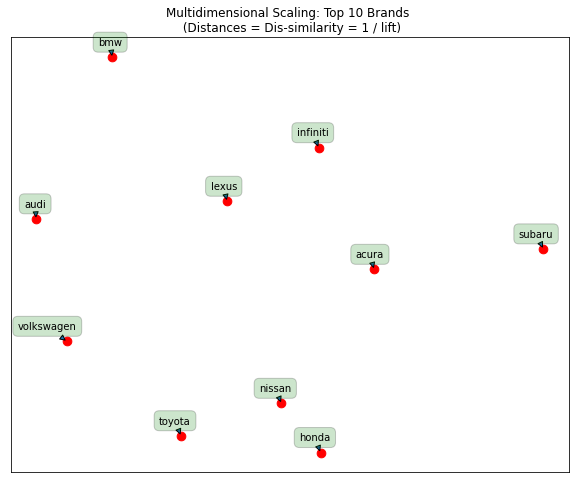

In [ ]:
from sklearn import manifold
from sklearn.manifold import MDS

mds=manifold.MDS(n_components=2, dissimilarity ='precomputed', random_state=10)
results=mds.fit(dissimilarity_mtx)
coordinates=results.embedding_

x = coordinates[:,0]
y = coordinates[:,1]

plt.figure(figsize=(10,8))
plt.scatter(x,y, marker='o', color='red', s=75)

for brand, x_coord, y_coord in zip(list(top10brand), x, y):
  plt.annotate(s=brand, 
               xy=(x_coord,y_coord),
               xytext = (10, 10),
               textcoords = 'offset points', 
               ha = 'right', 
               va = 'bottom',
               bbox = dict(boxstyle = 'round,pad=0.5', fc = 'green', alpha = 0.2),
               arrowprops = dict(arrowstyle = 'simple', connectionstyle = 'arc3,rad=0'))

plt.xticks([])
plt.yticks([])
plt.title('Multidimensional Scaling: Top 10 Brands \n (Distances = Dis-similarity = 1 / lift)')
plt.show()


# TASK E: Insights from C & D

To offer some insights to our client from part C and D, we would like to first gain some understanding with the numbers and graphs we created. 

**Part C (Lift Ratio between Top 10 Brands)**

In part C, we calculated the lift ratio between the top 10 mentioned brands in the Entry Level Luxury Forum. From what we've discussed in class, we know that a lift ratio of greater than 1 signifies a significant relationship. In fact, the greater the lift ratio value, the more significant the relationship is. When referencing the Lift Matrix, we can conclude the top 6 relationship ratios. They all have a lift ratio greater than 3: Lexus and Infiniti (3.71); Toyota and Honda (4.02); Toyota and Lexus (3.08); Nissan and honda (3.96); Nissan and Toyota (3.75); Volkswagen and Audi (4.2). These high lift ratios imply that any of the above two brands occur together more often than if they were independent. It is also interesting to note that all of the top 10 brands had a signifiacnt lift ratio.

Volkswagen and Audi has the highest lift ratio with a value of 4.2 meaning that Volkswagen and Audi amongst the forum scraped was the most commonly mentioned independent car brands in relation to each other in form of similarity or comparison. Additionally, it is interesting to note that the Volkswagen group owns Audi as this would also explain why both brands have such a high lift ratio. We found these high lift ratios interesting because brand groups (such as Volkswagen & Audi and Toyota & Honda) usually originate from the same country (Germany and Japan respectively) and produce comparable car models that tend to target similar customer segments (like Toyota RAV4 and Honda CR-V). Based on the analysis, the client company can focus on the characteristic differences and switching behaviors in these groups of brands to generate additional competitive advantages in the market. 



**Part D (MDS Map)**

In part D, we built a multi-dimentional scaling map by calculating the distances based on co-mention lift ratios obtained from part C. The MDS map provides a visualization to have a better understanding of the relationships and differences between each brand since we can now see highly correlated brands from clusters.

One potential business application when observing such values is to utilize the significant relationships to predict potential customer switching behavior. An example of this would be to promote brand A by focusing on people who currently own a car from brand B in the same cluster as the promoting brand. According to this chart, brands with a closer relationship may indicate that people who currently own brand B is more likely to switch to brand A. 


# TASK F: Top 5 Attributes

5. **Top 5 Attributes (Frequency Table)**

In [ ]:
#From the word frequency file, the top 5 attributes are:
top5feature = ['performance','engine','price','power','interior']
feature_freq = word_freq[word_freq['word'].map(lambda x: x in top5feature)].reset_index(drop=True)
feature_freq

,word,freq
0,performance,663
1,engine,444
2,price,409
3,power,375
4,interior,342


In [ ]:
comments.head(5)

,reviewer,date,comment,tokenization,filtered_cmnt,bmw,acura,audi,honda,infiniti,...,nissan,subaru,volkswagen,ford,lexus,performance,engine,price,power,interior
0,merc1,March 2002,"I personally think that with a few tweaks the C320 could also sit at the top of this group. It's still more of a entry-level luxury sedan than Mercedes would lead you to believe. The C320 ""Sport"" needs to have it's suspension retuned to accept 17 inch tires without a harsh ride. MB also needs to stop forcing metal trim and black leather on everyone that wants the sport package. The C240's 6-speed wouldn't hurt either if offered on the C320, though it needs to be ""fixed"" first. That said, my favorite of the group is (gasp!) the new A4 3.0. The A4 easily has the best interior of any sub-40K car, combine that with stunning looks and a body that is as rigid as any ever made and you have my personal favorite. The single thing I don't like about the A4 is the grey trim around the bottom of the car. This trim doesn't match any of the body colors, as it should be body color anyway. This is an excellent car and in my opinion the best there is under 40K. The upcoming A4 Convertible, Coupe and S4 WILL all be winners. The BMW 330i is now an old favorite, but I'm (of all people) starting to tire of the 3-Series just a bit, save the M3 variants. I was kind of dissappointed by the 2002 facelift, they could have done a little more in the way of styling. I hope they do a little more for 2003 with the coupe models. The Acura TL-S is easily my favorite fwd car in this class. Wonderful engine (you actually can hear it) and decent handling for a front driver. Nice price, seats and what not, not hard to see why the TL is so popular. This car's main faults are styling and obvious cost-cutting in the interior, stereo, fake wood etc. Otherwise a standout. Lexus ES300. Nice, but not my type of car at all. This is one for the Buick set. The IS300 is half baked, but has a wonderful chassis. Styling is also in question here, it simply doesn't look like a 35K car (grown). The interior is gawd-awful. Bet on the next IS300 being done right from the start. In their defense Toyota didn't initially intend for this car to be sold in the U.S. so it was a rush job. The CTS holds the greatest unrealized potential here. I've seen several now, and each time I see one they look better and better. Again like the C320, IS300 the car has interior issues. The dash feels like it was made by Rubbermaid. If you're going to be stingy with wood trim, why bother? Half of the steering wheel in wood, and very little anywhere else in the car??? The seats are very good though, as is the handling. A work in progress. The G35 looks like it may have a winning chassis, but the interior, though clean looking seems to be styled about 10 years ago, lots of square shapes and flat surfaces. Another great engine, waiting to drive this one.Don't really care much for the X-Type. If I were a Jaguar man I'd be truly pissed at Ford and Jaguar for this one. They are actually selling a fwd X-Type in England and I've read where they're thinking about selling it here! Hell no. The car should have been rwd not awd. Some will tell you that this was done to compete with Audi. Thats BS, awd was the only way to keep the car from being fwd, WITHOUT spending the money to convert the car to rwd. It is a good looking car though and that Jaguar ""leaper"" will be enough for some, but this car has to grow on me. The Chrysler 300M is about as close to an Audi that American cars come. This new 300M ""Special"" is truly a good looking car inside and out. One problem: Where is the performance???? A 255hp car *in this class) with a 0-60 time over 8 seconds is not accpetable. Something is not right here. Some say engine, transmission and/or gearing, but whatever it is, Chrysler needs to let some MB engineers have a look at this car. The heavier E320 with less power is faster. I still like this car, but it's no lust object once you get p

In [ ]:
for feature in top5feature:
  comments[feature] = comments['filtered_cmnt'].map(lambda x: 1 if feature in x else 0)

#Lift matrix for top_5_features and top_10_brands
feature_matrix = pd.DataFrame(index=top10brand, columns=top5feature)

for brand in top10brand:
  num_brand = sum(comments[brand]==1)
  for feature in top5feature:
      num_feature = sum(comments[feature]==1)
      co_mention = sum((comments[brand]==1) & (comments[feature]==1))
      lift = len(comments)*co_mention/(num_brand*num_feature)
      feature_matrix.loc[brand, feature] = lift
feature_matrix

,performance,engine,price,power,interior
bmw,1.45574,1.45457,1.561499,1.54999,1.206471
acura,1.402182,1.658454,1.530319,1.865429,1.614811
audi,1.396011,1.824012,2.206398,1.943667,2.131213
honda,1.504068,1.461214,1.938758,1.762115,1.370066
infiniti,1.503735,1.477265,1.699902,1.469228,1.841138
lexus,1.49861,1.729201,1.693139,1.445205,2.288945
toyota,1.517483,1.681204,1.706046,1.211636,1.470893
nissan,1.358974,1.722973,1.205379,2.176,1.342105
subaru,1.756535,1.202178,1.483016,1.811573,2.199199
volkswagen,1.445732,1.619123,2.343571,2.008329,1.401346


From the feature matrix:
- SUBARU is most strongly associated with 'performance'
- AUDI is most strongly associated with 'engine'
- VOLKSWAGEN is most strongly associated with 'price'
- NISSAN is most strongly associated with 'power'
- LEXUS is most strongly associated with 'interior'

# TASK G

Through the first step of Task F, we observed how frequent certain features were mentioned by customers on the forum. The most frequently mentioned top features are the ones customer care about the most. The top 5 features were performance (663), engine (444), price (409), power (375), and interior (342). From there, we calculated and obtained the lift matrix for top_5_features and top_10_brands. This matrix provides useful information which show us which brands are strongly associated with what features. 

Assuming all sentiments are positive, we can utilize the feature that was most strongly associated with the car brand to market the product as a unique selling proposition. For example, Subaru can emphasize and continue to build the car's brand and mission of providing the customer with the best "performance" when advertising Subaru models.



#TASK H: Aspirations

In [ ]:
# conduct a function to get all two consecutive words into a list of sets for each comment
from nltk.util import ngrams

def twogram(cmnt):
  tokens = word_tokenize(cmnt)
  tokens = [word.lower() for word in tokens if word.lower() not in stop_words]
  bigrams = list(ngrams(tokens, 2))
  return list(set(bigrams))

comments_df['Bigrams'] = comments_df['comment'].map(twogram)


In [ ]:
# a sample aspirational word list we generated to decide if that certain comment is aspirable or not

aspirational_word = [('love','buy'),
                     ('love','purchase'),
                     ('like','buy'),
                     ('love','have'),
                     ('want','buy'),
                     ('wish','buy'),
                     ('eager','buy'),
                     ('desired','buy'),
                     ('future','car'),
                     ('future','vehicle'),
                     ('near','future'),
                     ('desired','car'),
                     ('buy','new'),
                     ('purchase','new'),
                     ('next','purchase'),
                     ('dream','car'),
                     ('fancy','car')]

In [ ]:
all_model = list(set(model_dict.values()))
all_model.append('lexus')

In [ ]:
# function to check if certain comment has desired bigram sets to show aspiration
def check_aspir(twograms):
  for s in twograms:
    if s in aspirational_word:
      return 1
      break

comments_df['Aspirable'] = comments_df['Bigrams'].map(check_aspir)
comments_df['Aspirable'].fillna(0, inplace=True)

In [ ]:
comments_df.columns

Index(['reviewer', 'date', 'comment', 'tokenization', 'filtered_cmnt',
       'Bigrams', 'Aspirable', 'toyata', 'volkwagen', 'chevrolet', 'hyundai.',
       'mercedes', 'lincoln', 'mercury', 'nissan', 'pontiac', 'toyota',
       'problem', 'kia.', 'mazda', 'kia', 'subaru', 'hyundai', 'seat',
       'volkswagen', 'hyundai,', 'suzuki', 'audi', 'saturn', 'nissan.',
       'infiniti', 'mercedes-benz', 'sedan', 'bmw', 'mitsubishi', 'chrysler',
       'hyndai kia', 'acura', 'cadillac', 'car', 'buick', 'honda', 'dodge',
       'ford', 'volvo', 'lexus'],
      dtype='object')

In [ ]:
#Lift matrix for aspiration value
aspiration = comments_df.columns[[6]]
aspir_mtrx = pd.DataFrame(index=all_model, columns=aspiration)

for brand in all_model:
  comments_df[brand] = comments_df['filtered_cmnt'].map(lambda x: 1 if brand in x else 0)

for brand in all_model:
  num_brand = sum(comments_df[brand]==1)
  num_aspir = sum(comments_df['Aspirable']==1)
  co_exist = sum((comments_df[brand]==1) & (comments_df['Aspirable']==1))
  lift = 0 if (num_brand * num_aspir) == 0 else len(comments_df)*co_exist/(num_brand * num_aspir)
  aspir_mtrx.loc[brand]=lift
aspir_mtrx.sort_values(by = 'Aspirable', ascending=False, inplace=True)
aspir_mtrx.head(10)

,Aspirable
mitsubishi,9.667311
lincoln,4.253617
honda,2.811886
toyota,2.762089
infiniti,2.511979
cadillac,2.262562
pontiac,2.126809
chevrolet,2.064863
acura,1.958387
lexus,1.921815


From the aspiration table result: 

The most aspirational brand in general is **mitsubishi**

The most aspirational among the top 10 brands is **HONDA**



6. **Overview of Analysis**

To analyze the most aspirational brand in our data in term of people's desire to buy or own the cars, we calculated the lift ratio for each specific car brand and the aspiration of each comment. Before actually doing the analysis, we have listed all the aspirational words that express people's wants of buying or owning the car, including "love buy", "want buy", "dream car", etc. We created a list of sets to store these aspirational phrases (after removing the stop words in previous parts) as bigrams. Next, we used each comment as one entry to segment the comment into sets of two words. If the word set contains the aspirational bigrams in the bigram list, we will set its value to 1, meaning that the owner of this comment has expressed the emotion of buying or owning. On this basis, if a car brand occurs in this comment as well, we would count it as the co-mention of an aspirational words and car brands, meaning the owner of the comment is wanting to buy or own the car. Then, we would calculate the lift ratio with number of co-mentions, number of each car brands based on the co-mentions, and the number of bigrams to get the most aspirational brand. 

From the aspiration table result, we found the most aspirational brand in general to be Mitsubishi, and the most aspirational among the top 10 brands is Honda. It was interesting to note that the most aspirational brand, Mitsubishi, was not amongst the top 10 brands. Thus, we thought it would be helpful to include the most aspirational brand among the top 10 mentioned brands because it had been mentioned the most in the forum data we scrapped. Since we also did the top frequent attribute analysis, we think it's a thoughtful method to derive business insights about why it gets the most mentions or attention in the forum.

7. **What are the business implications for this brand**

With our most aspirational brand being Mitsubishi, we can say that it is the brand with most co-mentions of aspirational words and car brands. The client company can change its marketing strategy given that Mitsubishi is the most aspirational brand. By inspecting the special characteristics and features customers value the most with Mitsubishi, the client company will be able to emphasize these in their marketing campaign. Additionally, they can also examine the differences between the most and least aspirational brands to improve the features with the other brands. Combining this analysis with previous analysis like feature analysis, the client company would better understand the factors cause Mitsubishi to be the most aspirational brand. Therefore, the client company can segment customers into different clusters to better target customer preferences. Moreover, we can obtain the lift ratio for Mitsubishi with other brands to find out its co-mention relationships to assess the feature comparison and/or switching behavior between Mitsubishi with other brands. In conclusion, we're meeting the necessary factors of successful segmentation like differentiable, identifiable, actionable and stable. Through the analysis, we obtained a better understanding of the fundamental questions of segmentation: who are the customers (WHO), what have the customers done (WHAT), and why do customers make the decisions they do (WHY). The brand will be able to make more effective and strategically important marketing decisions based on what we have reported. 

# Conclusion: Advice/Insights for Client Company

- Carefully examine the lift ratio and MDS map for top ten brands. Focus on finding the characteristic differences and switching behavior in these different brands.

- Find out highly correlated brands from different clusters on the MDS map. Brands that are closer are probably easily swithching brands for each other.

- Focus on the aspirational analysis and find out common characteristics among top ranking cars. When marketing on these brands, highlight the standout attributes for each brand in the attribute analysis.

- Compare results across different analysis, integrate information from different tables, and analyze the correlation between each analysis to better understand customer preferences and customer segmentation.